##### Homework description:
1. Implement your own VGG-16, ResNet for image segmentation
  - for VGG16: tf.keras.applications.vgg16.VGG16 (you need to write upsampling mechanism)
2. Investigate: https://keras.io/api/applications/
3. Investigate: https://tfhub.dev/
4. Investigate: https://huggingface.co/

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

# Preprocessing

In [ ]:
image_width = 224
image_height = 224

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0 # normalize to [0, 1] range
  input_mask -= 1 # convert pixels in the segmentation mask from {1, 2, 3} labeling to {0, 1, 2}
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (image_width, image_height))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (image_width, image_height))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 8
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_batches = (
    train_images
    .cache()
    # fills a buffer with BUFFER_SIZE elements, then randomly samples elements from this buffer, replacing the
    # selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the
    # full size of the dataset is required
    .shuffle(BUFFER_SIZE) 
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]

In [ ]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# VGG16

In [ ]:
# vgg16_base_model = tf.keras.applications.vgg16.VGG16()

vgg16_base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(image_width, image_height, 3),
    include_top=False)

In [ ]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

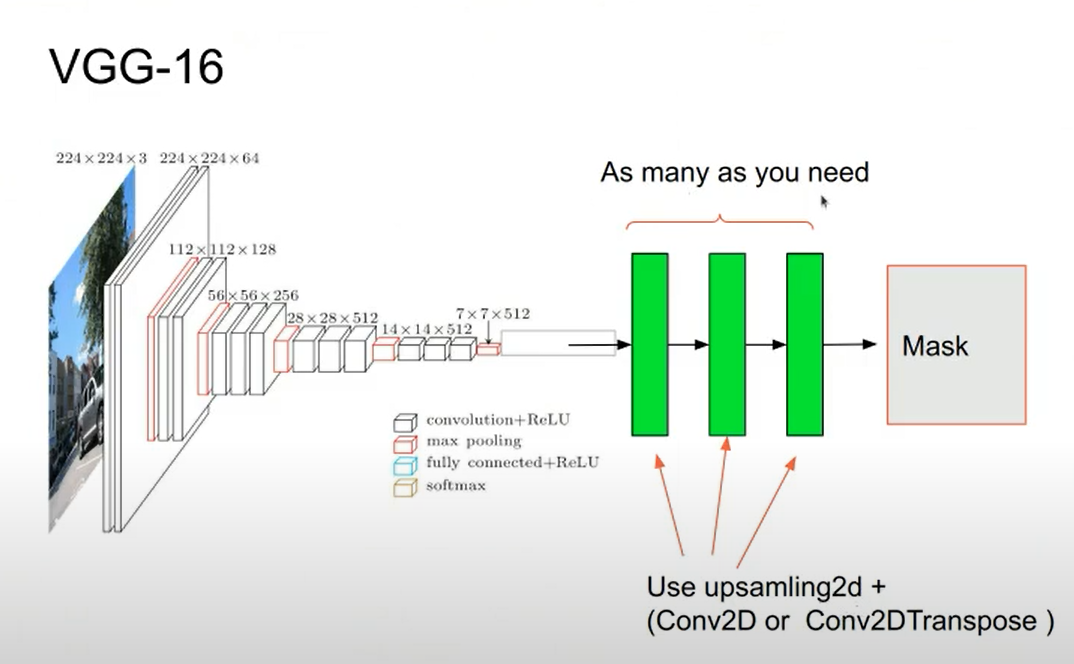

In [ ]:
# model = tf.keras.Sequential([i for i in vgg16_base_model.layers[:-4]])

vgg16_base_model.trainable = False

x = vgg16_base_model(inputs=vgg16_base_model.input, training=False)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(512, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(256, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(128, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(64, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)

# outputs = tf.keras.layers.Conv2D(3, (2, 2), padding='same', activation='softmax')(x)
number_of_classes = 3
outputs = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

model_vgg16 = tf.keras.Model(vgg16_base_model.input, outputs)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model_vgg16.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 512)      0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 512)      4194816   
 nspose)                                                         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 512)      0         
 2D)                                                             
                                                             

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

def train_model(model):
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
  EPOCHS = 10

  # trained on Google Colab's GPU

  model_history = model.fit(train_batches,
            epochs=EPOCHS,
            verbose=1,
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_data=test_batches,
            callbacks=[callback])
  
  return model_history

In [ ]:
model_vgg16_history = train_model(model_vgg16)

Epoch 1/10
1840/1840 [==============================] - 140s 72ms/step - loss: 0.4771 - accuracy: 0.8002 - val_loss: 0.4265 - val_accuracy: 0.8198
Epoch 2/10
1840/1840 [==============================] - 126s 69ms/step - loss: 0.4036 - accuracy: 0.8286 - val_loss: 0.4015 - val_accuracy: 0.8309
Epoch 3/10
1840/1840 [==============================] - 127s 69ms/step - loss: 0.3728 - accuracy: 0.8407 - val_loss: 0.3961 - val_accuracy: 0.8344
Epoch 4/10
1840/1840 [==============================] - 127s 69ms/step - loss: 0.3487 - accuracy: 0.8501 - val_loss: 0.3880 - val_accuracy: 0.8383
Epoch 5/10
1840/1840 [==============================] - 126s 69ms/step - loss: 0.3263 - accuracy: 0.8590 - val_loss: 0.4018 - val_accuracy: 0.8361
Epoch 6/10
1840/1840 [==============================] - 126s 69ms/step - loss: 0.3056 - accuracy: 0.8671 - val_loss: 0.3964 - val_accuracy: 0.8402


In [ ]:
def plot_losses(model_history):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  plt.figure()
  plt.plot(model_history.epoch, loss, 'r', label='Training loss')
  plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.ylim([0, 1])
  plt.legend()
  plt.show()

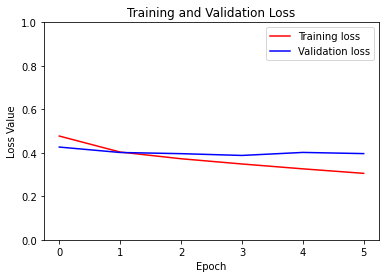

In [ ]:
plot_losses(model_vgg16_history)

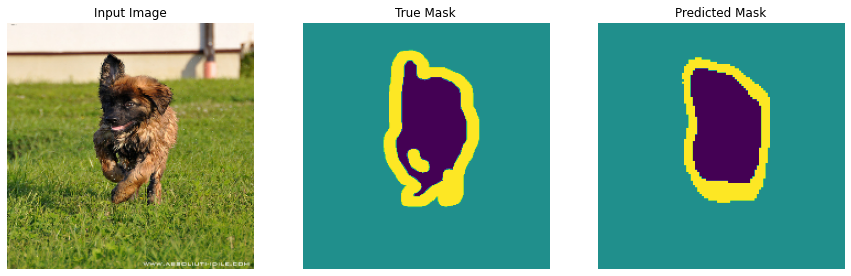

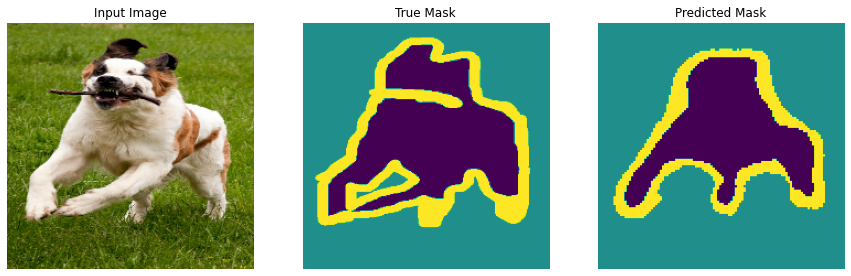

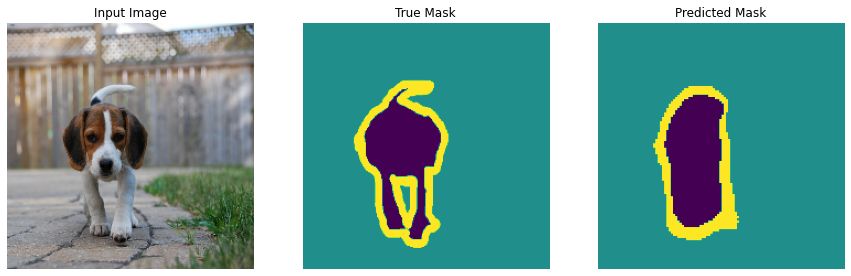

In [ ]:
show_predictions(model_vgg16, test_batches, 3)

# ResNet

In [ ]:
resnet_base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_shape=(image_width, image_height, 3),
    include_top=False)
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

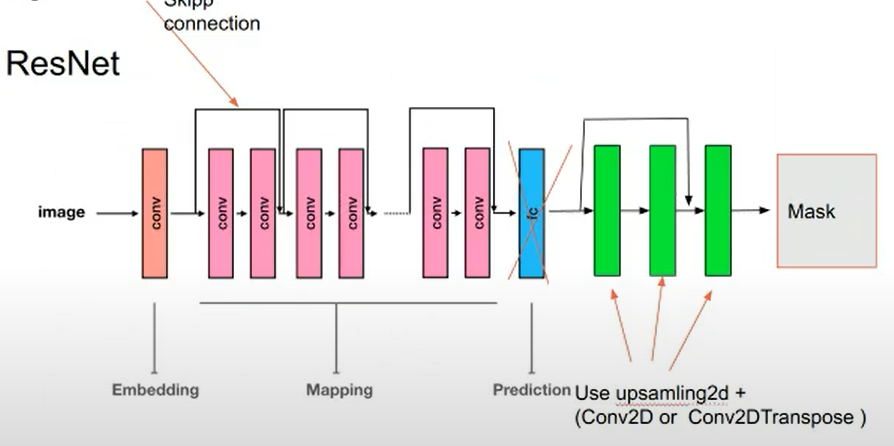

In [ ]:
resnet_base_model.trainable = False

x = resnet_base_model(inputs=resnet_base_model.input, training=False)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(512, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(256, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(128, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2DTranspose(64, (4, 4), padding='same', activation='relu')(x)

x = tf.keras.layers.UpSampling2D(2)(x)

number_of_classes = 3
outputs = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)

model_resnet = tf.keras.Model(resnet_base_model.input, outputs)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model_resnet.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 2048)     0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 512)      16777728  
 ranspose)                                                       
                                                                 
 up_sampling2d_6 (UpSampling  (None, 28, 28, 512)      0         
 2D)                                                             
                                                           

In [ ]:
model_resnet_history = train_model(model_resnet)

Epoch 1/10
1840/1840 [==============================] - 156s 83ms/step - loss: 0.7261 - accuracy: 0.6999 - val_loss: 0.7389 - val_accuracy: 0.6930
Epoch 2/10
1840/1840 [==============================] - 152s 82ms/step - loss: 0.6966 - accuracy: 0.7122 - val_loss: 0.7144 - val_accuracy: 0.7038
Epoch 3/10
1840/1840 [==============================] - 183s 99ms/step - loss: 0.6786 - accuracy: 0.7194 - val_loss: 0.6944 - val_accuracy: 0.7110
Epoch 4/10
1840/1840 [==============================] - 150s 81ms/step - loss: 0.6649 - accuracy: 0.7255 - val_loss: 0.6772 - val_accuracy: 0.7165
Epoch 5/10
1840/1840 [==============================] - 149s 81ms/step - loss: 0.6539 - accuracy: 0.7298 - val_loss: 0.7061 - val_accuracy: 0.7074
Epoch 6/10
1840/1840 [==============================] - 150s 81ms/step - loss: 0.6459 - accuracy: 0.7326 - val_loss: 0.6537 - val_accuracy: 0.7276
Epoch 7/10
1840/1840 [==============================] - 150s 81ms/step - loss: 0.6376 - accuracy: 0.7359 - val_loss: 0

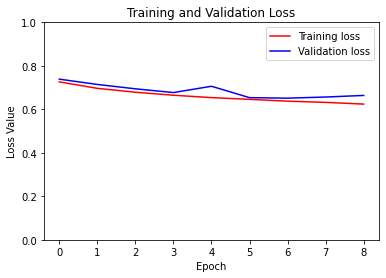

In [ ]:
plot_losses(model_resnet_history)

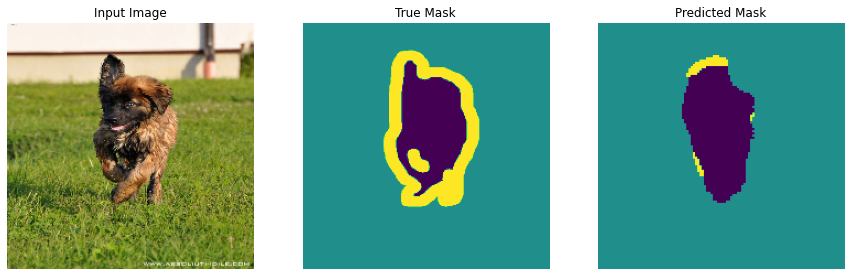

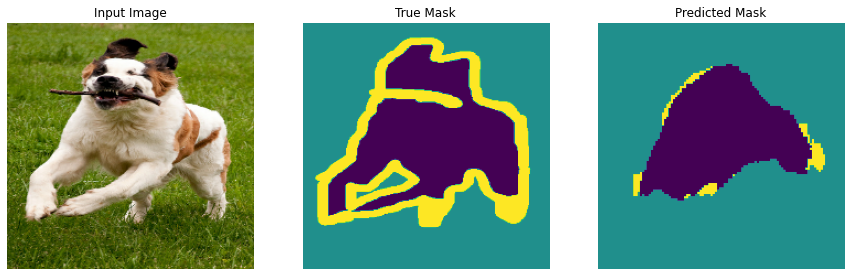

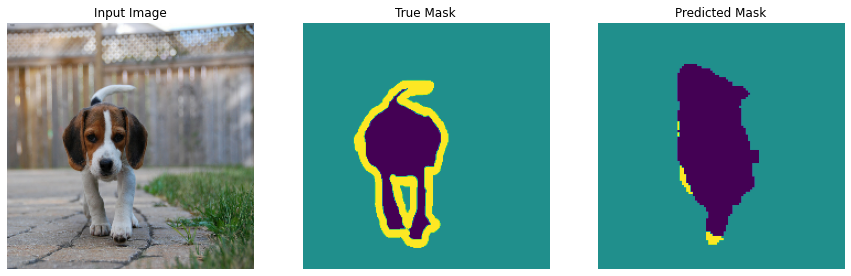

In [ ]:
show_predictions(model_resnet, test_batches, 3)

# ResNet attempt #2

In [ ]:
resnet_base_model2 = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',
    input_shape=(image_width, image_height, 3),
    include_top=False)

resnet_base_model2.trainable = False
resnet_base_model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# encoder
s1 = resnet_base_model2.layers[0].output
s2 = resnet_base_model2.get_layer('conv1_relu').output
s3 = resnet_base_model2.get_layer('conv2_block3_out').output
s4 = resnet_base_model2.get_layer('conv3_block4_out').output

# bridge
b1 = resnet_base_model2.get_layer('conv4_block6_out').output

# decoder
x2 = tf.keras.layers.UpSampling2D(2)(b1)
x2 = tf.keras.layers.concatenate([x2, s4])
x2 = tf.keras.layers.Conv2D(512, (4, 4), padding='same', activation='relu')(x2)

x2 = tf.keras.layers.UpSampling2D(2)(x2)
x2 = tf.keras.layers.concatenate([x2, s3])
x2 = tf.keras.layers.Conv2D(256, (4, 4), padding='same', activation='relu')(x2)

x2 = tf.keras.layers.UpSampling2D(2)(x2)
x2 = tf.keras.layers.concatenate([x2, s2])
x2 = tf.keras.layers.Conv2D(128, (4, 4), padding='same', activation='relu')(x2)

x2 = tf.keras.layers.UpSampling2D(2)(x2)
x2 = tf.keras.layers.concatenate([x2, s1])
x2 = tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation='relu')(x2)

outputs2 = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x2)

model_resnet2 = tf.keras.Model(resnet_base_model2.input, outputs2)

model_resnet2.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_resnet2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model_resnet2_history = train_model(model_resnet2)

Epoch 1/10
1840/1840 [==============================] - 335s 181ms/step - loss: 0.7332 - accuracy: 0.6943 - val_loss: 0.7367 - val_accuracy: 0.6870
Epoch 2/10
1840/1840 [==============================] - 384s 209ms/step - loss: 0.7085 - accuracy: 0.7024 - val_loss: 0.7195 - val_accuracy: 0.6941
Epoch 3/10
1840/1840 [==============================] - 384s 209ms/step - loss: 0.6850 - accuracy: 0.7130 - val_loss: 0.6741 - val_accuracy: 0.7193
Epoch 4/10
1840/1840 [==============================] - 329s 179ms/step - loss: 0.6642 - accuracy: 0.7231 - val_loss: 0.6700 - val_accuracy: 0.7189
Epoch 5/10
1840/1840 [==============================] - 329s 179ms/step - loss: 0.6474 - accuracy: 0.7310 - val_loss: 0.6505 - val_accuracy: 0.7286
Epoch 6/10
1840/1840 [==============================] - 330s 179ms/step - loss: 0.6342 - accuracy: 0.7366 - val_loss: 0.6342 - val_accuracy: 0.7374
Epoch 7/10
1840/1840 [==============================] - 328s 179ms/step - loss: 0.6263 - accuracy: 0.7402 - val_

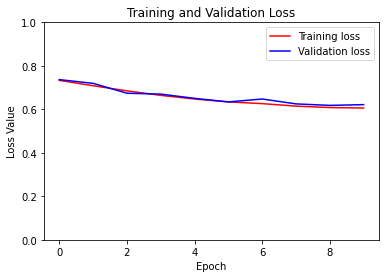

In [ ]:
plot_losses(model_resnet2_history)

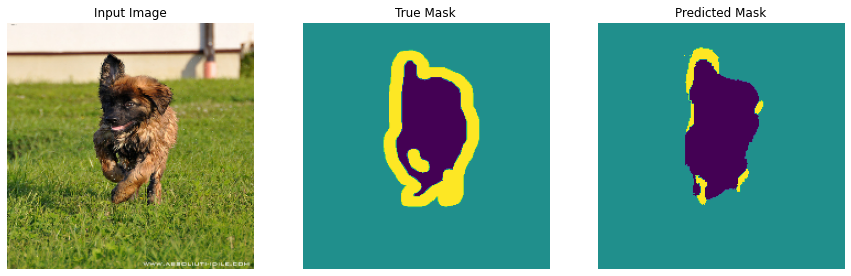

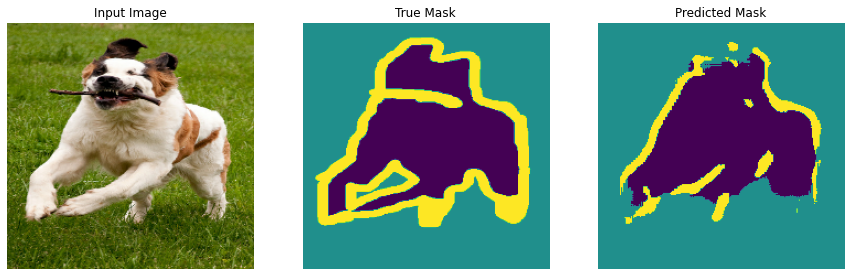

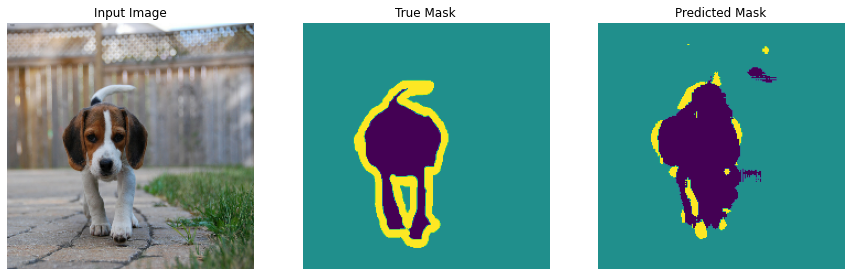

In [ ]:
show_predictions(model_resnet2, test_batches, 3)